# Clustering and Meanshift

Homework: get to the point whre i can implement some clustering algorithm on the GPU

- turn unsupervisied learning algorithms that try to group unlabelle data into clusters.

# Imports

In [2]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [3]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

# Create Data

In [14]:
n_clusters = 6
n_samples = 250

In [12]:
centroids = torch.rand(n_clusters, 2)*70 -35

In [7]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [9]:
def sample(m): 
    return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [15]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [17]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

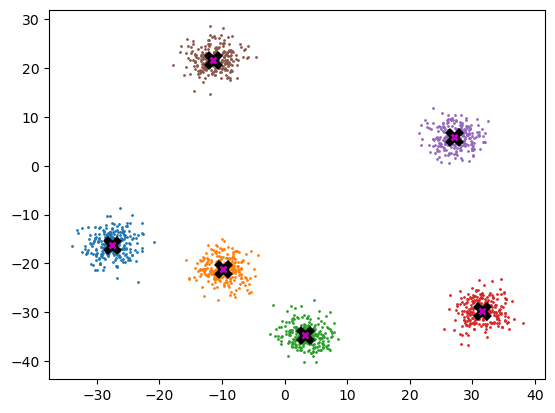

In [18]:
plot_data(centroids, data, n_samples)

## Mean shift

- Mean shift over clustering
    - It doesn't require selecting the number of clusters in advance, but instead just requires a bandwidth to be specified, which can be easily chosen automatically
    - It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.
    
    
The algorithm is as follows:

1. For each data point x in the sample X, find the distance between that point x and every other point in X
2. Create weights for each point in X by using the Gaussian kernel of that point's distance to x
     - This weighting approach penalizes points further away from x. If they are close, they have a higher weight, if they are further away, they have a smaller weight.
    - The rate at which the weights fall to zero is determined by the bandwidth, which is the standard deviation of the Gaussian
3. Update x as the weighted average of all other points in X, weighted based on the previous step

# Plotting and implementation

In [23]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [24]:
def plot(f):
    x = torch.linspace(0,10, 100)
    plt.plot(x, f(x))

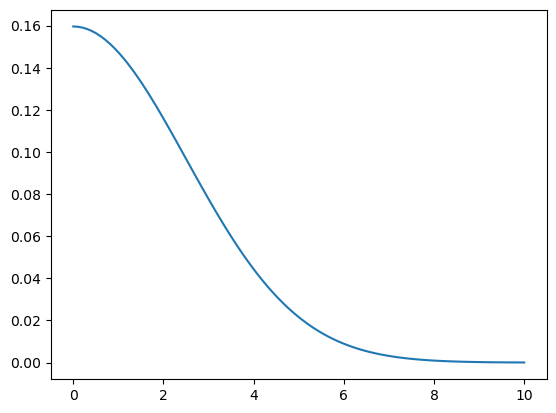

In [25]:
plot(partial(gaussian, bw=2.5))

Choose a bandwidth which covers two thirds of our data.

In [28]:
X = data.clone()
x = data[0]

In [29]:
x

tensor([-24.675, -17.655])

In [31]:
x.shape, X.shape, x[None, :].shape 

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

In [36]:
distance = ((x-X)**2).sum(1).sqrt() # this is the L2 Norm = RMSE, MAE = L1 Norm/ L1 loss and L2 loss
distance[:8]

tensor([0.000, 2.850, 2.313, 1.920, 2.817, 6.314, 2.781, 4.519])

In [41]:
distance = torch.einsum('ij,ij -> i',(x-X), (x-X)).sqrt()  #rewritten using einsum 
distance[:8]

tensor([0.000, 2.850, 2.313, 1.920, 2.817, 6.314, 2.781, 4.519])

In [44]:
weights = gaussian(distance, 2.5)
weights

tensor([0.160, 0.083, 0.104,  ..., 0.000, 0.000, 0.000])

In [45]:
weights.shape, X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [46]:
weights[:, None]*X

tensor([[-3.938, -2.817],
        [-2.271, -1.371],
        [-2.808, -1.840],
        ...,
        [-0.000,  0.000],
        [-0.000,  0.000],
        [-0.000,  0.000]])

In [55]:
def one_update(X):
    for i, x in enumerate(X):
        distance = ((x-X)**2).sum(1).sqrt() # this is the L2 Norm = RMSE, MAE = L1 Norm/ L1 loss and L2 loss
        weights = gaussian(distance, 2.5)
        X[i] = (weights[:, None]*X).sum(0)/weights.sum()

In [48]:
def meanshift(data):
    X = data.clone()
    for it in range(5):
        one_update(X)
    return X

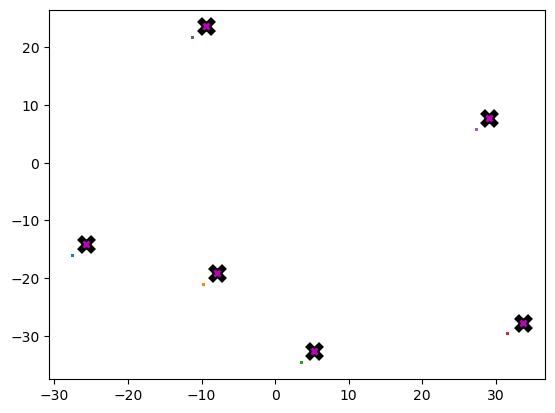

In [57]:
plot_data(centroids+2, meanshift(data), n_samples) # quite close

## Animation

In [58]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [60]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [61]:
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames = 5, interval=500, repeat=True)
plt.close()
HTML(ani.to_jshtml())